In [1]:
%load_ext autoreload
%autoreload 2
from pybaseball import statcast, pitching_stats
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from matplotlib import patches
%matplotlib inline

# use Statcast data (from 2015-2018) so we can get spin rate, etc.
train_data_dates = [('2015-04-05', '2015-10-04'),      # 2015 data
                    ('2016-04-03', '2016-10-02'),       # 2016 data
                    ('2017-04-02', '2017-10-01'),       # 2017 data
                    ('2018-03-29', '2018-10-01')]       # 2018 data

In [2]:
pitcher_season_stats = pitching_stats(2018)

cols_to_keep = ['Name', 'Strikes', 'Pitches', 'K/9', 'BB/9', 'K/BB', 'H/9', 'HR/9', 'AVG', 'WHIP', 'FIP', 'GB/FB', 'LD%', 'GB%', 'IFFB%', 'HR/FB',
                'O-Swing%', 'Z-Swing%', 'Swing%', 'O-Contact%', 'Z-Contact%', 'Contact%', 'Zone%', 'F-Strike%', 'SwStr%']
pitcher_season_stats = pitcher_season_stats[cols_to_keep]

# keep only pitchers with 500 pitches in a season
pitcher_season_stats = pitcher_season_stats[pitcher_season_stats['Pitches'] >= 500]

pitcher_season_stats['Strike Pct'] = pitcher_season_stats['Strikes'] / pitcher_season_stats['Pitches']
pitcher_season_stats.drop(['Strikes', 'Pitches'], axis=1, inplace=True)

pitcher_season_stats.rename(columns={'Name': 'player_name'}, inplace=True)

pitcher_season_stats.head()

,player_name,K/9,BB/9,K/BB,H/9,HR/9,AVG,WHIP,FIP,GB/FB,...,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,Strike Pct
41,Jacob deGrom,11.16,1.91,5.85,6.30,0.41,0.194,0.91,1.99,1.47,...,0.379,0.688,0.517,0.577,0.797,0.708,0.446,0.665,0.151,0.688979
92,Max Scherzer,12.24,2.08,5.88,6.12,0.94,0.187,0.91,2.65,0.72,...,0.358,0.701,0.520,0.539,0.775,0.690,0.474,0.657,0.162,0.688806
91,Justin Verlander,12.20,1.56,7.84,6.56,1.18,0.198,0.90,2.78,0.57,...,0.346,0.688,0.509,0.575,0.794,0.716,0.477,0.689,0.145,0.689816
57,Chris Sale,13.50,1.94,6.97,5.81,0.63,0.179,0.86,1.98,1.22,...,0.364,0.628,0.480,0.545,0.765,0.672,0.441,0.676,0.158,0.678812
133,Gerrit Cole,12.40,2.88,4.31,6.42,0.85,0.196,1.03,2.70,0.84,...,0.321,0.688,0.494,0.552,0.800,0.715,0.471,0.635,0.141,0.673319


In [3]:
# get the data from baseball savant
pitch_by_pitch_data = statcast(start_dt='2018-03-29', end_dt='2018-10-01')

# choose the columns we want to use for identifying Families
# NOTE: I've chosen to leave out pitch location, because averaging should just return the middle of the plate
cols_to_keep = ['pitcher', 'player_name', 'p_throws', 'pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z',
                'release_spin_rate', 'release_extension', 'pfx_x', 'pfx_z']  #, 'plate_x', 'plate_z']
pitch_by_pitch_data = pitch_by_pitch_data[cols_to_keep]

# make sure pitcher ID's are ints
pitch_by_pitch_data['pitcher'] = pitch_by_pitch_data['pitcher'].astype(int)

pitch_by_pitch_data.head()

This is a large query, it may take a moment to complete
Completed sub-query from 2018-03-29 to 2018-04-03
Completed sub-query from 2018-04-04 to 2018-04-09
Completed sub-query from 2018-04-10 to 2018-04-15
Completed sub-query from 2018-04-16 to 2018-04-21
Completed sub-query from 2018-04-22 to 2018-04-27
Completed sub-query from 2018-04-28 to 2018-05-03
Completed sub-query from 2018-05-04 to 2018-05-09
Completed sub-query from 2018-05-10 to 2018-05-15
Completed sub-query from 2018-05-16 to 2018-05-21
Completed sub-query from 2018-05-22 to 2018-05-27
Completed sub-query from 2018-05-28 to 2018-06-02
Completed sub-query from 2018-06-03 to 2018-06-08
Completed sub-query from 2018-06-09 to 2018-06-14
Completed sub-query from 2018-06-15 to 2018-06-20
Completed sub-query from 2018-06-21 to 2018-06-26
Completed sub-query from 2018-06-27 to 2018-07-02
Completed sub-query from 2018-07-03 to 2018-07-08
Completed sub-query from 2018-07-09 to 2018-07-14
Completed sub-query from 2018-07-15 to 2018-

,pitcher,player_name,p_throws,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,release_extension,pfx_x,pfx_z
0,445276,Kenley Jansen,R,FC,92.2,-1.9690,6.2644,2629.0,6.979,0.3852,1.3383
1,445276,Kenley Jansen,R,FC,93.0,-1.7689,6.2976,2686.0,7.003,0.5206,1.2567
2,445276,Kenley Jansen,R,FC,91.6,-1.7451,6.2154,2581.0,7.098,0.6363,1.1421
3,445276,Kenley Jansen,R,FF,93.1,-1.4250,6.1929,2243.0,7.273,-0.4317,1.3971
4,445276,Kenley Jansen,R,FC,91.4,-1.9144,6.2641,2658.0,7.103,0.5592,1.1846


In [4]:
# group the various pitch types into three types (fastball=FB, breaking=BR and off-speed=OS)
fastball_pitches = ['FC', 'FF', 'FA', 'FT', 'SI']
breaking_pitches = ['CU', 'KC', 'KN', 'SC', 'SL', 'GY']
offspeed_pitches = ['CH', 'EP', 'FO', 'FS']

# pitches to drop (pitch outs, intentional balls, uncategorized)
dropped_pitches = ['AB', 'AS', 'IN', 'NP', 'PO', 'UN']

# categorize pitches
def categorize_pitches(x):
    if x in fastball_pitches:
        return 'FB'
    elif x in breaking_pitches:
        return 'BR'
    elif x in offspeed_pitches:
        return 'OS'
    else:
        return x
pitch_by_pitch_data['pitch_type'] = pitch_by_pitch_data['pitch_type'].apply(categorize_pitches)

# drop any rows with non-pitch pitches
pitch_by_pitch_data = pitch_by_pitch_data[~pitch_by_pitch_data['pitch_type'].isin(dropped_pitches)]

# drop any rows with NaN for pitch type
pitch_by_pitch_data = pitch_by_pitch_data[pd.notnull(pitch_by_pitch_data['pitch_type'])]

# print out the breakdown of categorized pitch types
pitch_counts = Counter(pitch_by_pitch_data['pitch_type'])
print(pitch_counts)
print()
pitch_by_pitch_data.head()

Counter({'FB': 432995, 'BR': 199184, 'OS': 86202})



,pitcher,player_name,p_throws,pitch_type,release_speed,release_pos_x,release_pos_z,release_spin_rate,release_extension,pfx_x,pfx_z
0,445276,Kenley Jansen,R,FB,92.2,-1.9690,6.2644,2629.0,6.979,0.3852,1.3383
1,445276,Kenley Jansen,R,FB,93.0,-1.7689,6.2976,2686.0,7.003,0.5206,1.2567
2,445276,Kenley Jansen,R,FB,91.6,-1.7451,6.2154,2581.0,7.098,0.6363,1.1421
3,445276,Kenley Jansen,R,FB,93.1,-1.4250,6.1929,2243.0,7.273,-0.4317,1.3971
4,445276,Kenley Jansen,R,FB,91.4,-1.9144,6.2641,2658.0,7.103,0.5592,1.1846


In [5]:
pitcher_list = list(set(pitch_by_pitch_data['pitcher'].tolist()))
print(f"{len(pitcher_list)} pitchers in the data.")

pitcher_pitch_avgs_df = pd.DataFrame()

for pitcher in pitcher_list:
    
    pitcher_df = pitch_by_pitch_data[pitch_by_pitch_data['pitcher'] == pitcher]
    total_num_pitches = len(pitcher_df)

    pitch_types = ['FB', 'BR', 'OS']
    pitch_type_avgs = []
    for pitch_type in pitch_types:

        pitcher_pitch_df = pitcher_df[pitcher_df['pitch_type'] == pitch_type]
        num_pitches = len(pitcher_pitch_df)

        pitcher_pitch_df = pd.DataFrame(pitcher_pitch_df.groupby(['pitcher', 'player_name', 'p_throws', 'pitch_type']).mean())
        pitcher_pitch_df.columns = [pitch_type + ' ' + x for x in pitcher_pitch_df.columns.tolist()]

        pitcher_pitch_df.reset_index(inplace=True, drop=False)
        
        pitcher_pitch_df[pitch_type+'%'] = num_pitches / total_num_pitches

        pitcher_pitch_df.drop('pitch_type', axis=1, inplace=True)

        pitcher_pitch_df.set_index(['pitcher', 'player_name', 'p_throws'], inplace=True)

        pitch_type_avgs.append(pitcher_pitch_df)

    pitcher_pitch_avgs_df = pitcher_pitch_avgs_df.append(pd.concat(pitch_type_avgs, axis=1, join='inner'))

pitcher_pitch_avgs_df.reset_index(inplace=True, drop=False)

pitcher_pitch_avgs_df.head()

798 pitchers in the data.


,pitcher,player_name,p_throws,FB release_speed,FB release_pos_x,FB release_pos_z,FB release_spin_rate,FB release_extension,FB pfx_x,FB pfx_z,...,BR pfx_z,BR%,OS release_speed,OS release_pos_x,OS release_pos_z,OS release_spin_rate,OS release_extension,OS pfx_x,OS pfx_z,OS%
0,622608.0,Antonio Senzatela,R,93.620961,-2.285924,5.945654,2087.743354,6.358473,-0.365652,0.984344,...,-0.245062,0.272906,86.635338,-2.488155,5.849395,2121.796992,6.412444,-0.764528,0.745999,0.087042
1,596001.0,Jakob Junis,R,91.015995,-2.317984,5.567430,2006.536682,5.905861,-0.808441,0.922652,...,-0.278207,0.408034,84.741916,-2.263286,5.687574,1488.401198,5.751677,-0.754883,0.410291,0.058844
2,493603.0,Adam Ottavino,R,92.559733,-2.630619,5.449220,2338.377676,6.813658,-0.764796,0.559525,...,0.039236,0.468135,88.233333,-2.762600,5.329200,1794.333333,6.817667,-0.826567,0.332467,0.002360
3,593958.0,Eduardo Rodriguez,L,91.985239,1.793006,5.653759,2210.555085,5.805124,0.685681,1.007188,...,0.386618,0.072201,87.415822,1.771342,5.703651,2074.484787,5.987391,1.509818,0.425179,0.213143
4,452657.0,Jon Lester,L,89.987012,2.846886,5.631914,2269.320034,6.219825,0.411403,1.113000,...,-0.445862,0.157285,84.949826,2.824643,5.674921,1804.641115,6.179930,1.164385,0.470043,0.092313


In [6]:
print(pitcher_pitch_avgs_df.shape)
print(pitcher_season_stats.shape)
pitcher_data = pd.merge(pitcher_pitch_avgs_df, pitcher_season_stats, how='inner', on='player_name')
print(pitcher_data.shape)
pitcher_data.head()

(655, 27)
(470, 24)
(414, 50)


,pitcher,player_name,p_throws,FB release_speed,FB release_pos_x,FB release_pos_z,FB release_spin_rate,FB release_extension,FB pfx_x,FB pfx_z,...,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,Strike Pct
0,622608.0,Antonio Senzatela,R,93.620961,-2.285924,5.945654,2087.743354,6.358473,-0.365652,0.984344,...,0.247,0.665,0.427,0.670,0.868,0.803,0.431,0.613,0.084,0.621321
1,596001.0,Jakob Junis,R,91.015995,-2.317984,5.567430,2006.536682,5.905861,-0.808441,0.922652,...,0.318,0.640,0.464,0.617,0.903,0.796,0.454,0.627,0.095,0.647287
2,493603.0,Adam Ottavino,R,92.559733,-2.630619,5.449220,2338.377676,6.813658,-0.764796,0.559525,...,0.261,0.556,0.391,0.495,0.804,0.688,0.440,0.602,0.122,0.630503
3,593958.0,Eduardo Rodriguez,L,91.985239,1.793006,5.653759,2210.555085,5.805124,0.685681,1.007188,...,0.316,0.710,0.474,0.629,0.857,0.766,0.400,0.615,0.111,0.627324
4,452657.0,Jon Lester,L,89.987012,2.846886,5.631914,2269.320034,6.219825,0.411403,1.113000,...,0.272,0.680,0.438,0.678,0.879,0.805,0.406,0.574,0.085,0.615187


In [7]:
for col in pitcher_data.columns.tolist():
    print(col, sum(pd.isnull(pitcher_data[col])))

pitcher 0
player_name 0
p_throws 0
FB release_speed 0
FB release_pos_x 0
FB release_pos_z 0
FB release_spin_rate 0
FB release_extension 0
FB pfx_x 0
FB pfx_z 0
FB% 0
BR release_speed 0
BR release_pos_x 0
BR release_pos_z 0
BR release_spin_rate 0
BR release_extension 0
BR pfx_x 0
BR pfx_z 0
BR% 0
OS release_speed 0
OS release_pos_x 0
OS release_pos_z 0
OS release_spin_rate 0
OS release_extension 0
OS pfx_x 0
OS pfx_z 0
OS% 0
K/9 0
BB/9 0
K/BB 0
H/9 0
HR/9 0
AVG 0
WHIP 0
FIP 0
GB/FB 0
LD% 0
GB% 0
IFFB% 0
HR/FB 0
O-Swing% 0
Z-Swing% 0
Swing% 0
O-Contact% 0
Z-Contact% 0
Contact% 0
Zone% 0
F-Strike% 0
SwStr% 0
Strike Pct 0


In [8]:
pitcher_data.dropna(inplace=True)
pitcher_data.sort_values(by=['p_throws', 'K/9'], ascending=[True, False], inplace=True)
pitcher_data.head(10)

,pitcher,player_name,p_throws,FB release_speed,FB release_pos_x,FB release_pos_z,FB release_spin_rate,FB release_extension,FB pfx_x,FB pfx_z,...,O-Swing%,Z-Swing%,Swing%,O-Contact%,Z-Contact%,Contact%,Zone%,F-Strike%,SwStr%,Strike Pct
287,547973.0,Aroldis Chapman,L,98.892931,0.678041,6.109340,2499.511046,6.668879,0.397399,1.443647,...,0.329,0.613,0.448,0.551,0.708,0.641,0.419,0.585,0.161,0.627174
180,623352.0,Josh Hader,L,94.520212,3.431532,5.153169,2036.212909,6.743543,0.780306,1.395913,...,0.327,0.737,0.519,0.528,0.687,0.634,0.468,0.605,0.190,0.670213
280,519242.0,Chris Sale,L,94.846569,3.300821,5.221923,2330.125817,6.086654,1.285492,0.864539,...,0.364,0.628,0.480,0.545,0.765,0.672,0.441,0.676,0.158,0.678812
277,605240.0,Jace Fry,L,90.652568,2.917398,6.342650,2530.457192,5.334209,0.428506,0.489956,...,0.347,0.577,0.441,0.454,0.843,0.662,0.409,0.617,0.149,0.629630
398,620454.0,Jose Castillo,L,94.741261,2.143288,6.287592,2229.776504,6.223037,0.577077,1.251087,...,0.314,0.632,0.457,0.523,0.794,0.692,0.451,0.713,0.141,0.640823
382,448281.0,Sean Doolittle,L,93.791439,2.011977,6.024828,2210.322404,6.237466,0.273552,1.651603,...,0.371,0.770,0.558,0.598,0.750,0.697,0.469,0.706,0.169,0.695161
11,608331.0,Max Fried,L,93.022985,1.383931,6.213877,2037.889552,6.305125,0.382801,1.014229,...,0.277,0.626,0.420,0.495,0.823,0.696,0.412,0.578,0.128,0.605954
149,572020.0,James Paxton,L,94.180178,2.527853,6.205287,2250.557749,6.144073,0.808552,1.153898,...,0.360,0.700,0.524,0.559,0.821,0.728,0.483,0.662,0.143,0.678448
223,553878.0,Felipe Vazquez,L,98.013706,2.481734,5.449303,2553.487310,5.715274,0.788724,1.135637,...,0.311,0.742,0.525,0.516,0.804,0.718,0.497,0.625,0.148,0.672213
36,571578.0,Patrick Corbin,L,90.769357,2.240702,6.283540,2236.294619,6.257396,0.972741,1.082480,...,0.380,0.643,0.470,0.526,0.827,0.668,0.344,0.644,0.156,0.642903


## Split Into Two Groups: Lefties and Righties

In [9]:
lh_pitcher_data = pitcher_data[pitcher_data['p_throws'] == 'L']
print(f"Number of LH pitchers: {lh_pitcher_data.shape[0]}")

rh_pitcher_data = pitcher_data[pitcher_data['p_throws'] == 'R']
print(f"Number of RH pitchers: {rh_pitcher_data.shape[0]}")

Number of LH pitchers: 108
Number of RH pitchers: 306


## Lefties Analysis: Rescaling, PCA and Clustering 

Number of original dimensions: 47


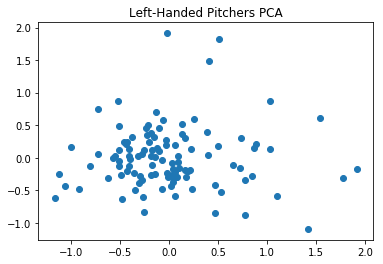

In [82]:
lh_pitcher_data.reset_index(inplace=True, drop=True)

# keep pitcher ID and name
lh_pitcher_data_ID_name = lh_pitcher_data[['pitcher', 'player_name']]

# data for clustering
lh_pitcher_data_clustering = lh_pitcher_data.drop(['pitcher', 'player_name', 'p_throws'], axis=1)
print(f"Number of original dimensions: {lh_pitcher_data_clustering.shape[1]}")

# rescale 
lh_scaler = MinMaxScaler()
lh_pitcher_data_clustering_scaled = pd.DataFrame(lh_scaler.fit_transform(lh_pitcher_data_clustering))

# perform PCA
lh_pca = PCA(n_components=2)

lh_pitcher_data_clustering_pca = pd.DataFrame(lh_pca.fit_transform(lh_pitcher_data_clustering_scaled))

plt.scatter(lh_pitcher_data_clustering_pca[[0]], lh_pitcher_data_clustering_pca[[1]])
plt.title("Left-Handed Pitchers PCA")
plt.show()

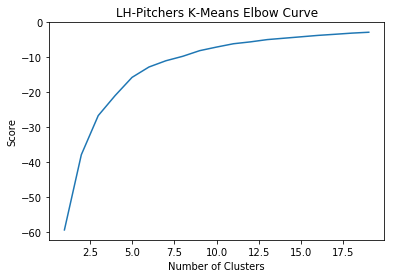

In [83]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

score = [kmeans[i].fit(lh_pitcher_data_clustering_pca).score(lh_pitcher_data_clustering_pca) for i in range(len(kmeans))]

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('LH-Pitchers K-Means Elbow Curve')
plt.show()

In [84]:
# remove a few "noisy" pitchers
noisy_pitchers_id = [21, 103, 107]

lh_pitcher_data_clustering_pca.drop(noisy_pitchers_id, axis=0, inplace=True)

In [88]:
lh_kmeans = KMeans(n_clusters=4).fit(lh_pitcher_data_clustering_pca)

lh_pitcher_data_clustering_pca['cluster_number'] = lh_kmeans.predict(lh_pitcher_data_clustering_pca)

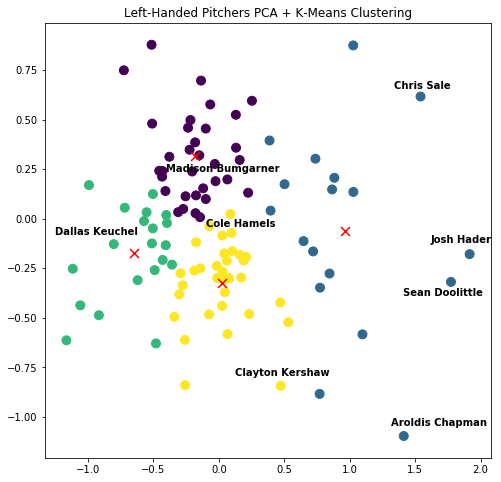

In [126]:
plt.figure(figsize=(8,8))
plt.scatter(lh_pitcher_data_clustering_pca.iloc[:, 0], lh_pitcher_data_clustering_pca.iloc[:, 1], c=lh_kmeans.labels_, s=80)
plt.scatter(lh_kmeans.cluster_centers_[:,0], lh_kmeans.cluster_centers_[:,1], marker='x', c='r', s=80)

plt.text(x=-0.405413, y=0.239189, s='Madison Bumgarner', fontdict={'fontweight': 'bold'})
plt.text(x=-1.254943, y=-0.079238, s='Dallas Keuchel', fontdict={'fontweight': 'bold'})
plt.text(x=1.313198, y=-1.04534, s='Aroldis Chapman', fontdict={'fontweight': 'bold'})
plt.text(x=1.616603, y=-0.119073, s='Josh Hader', fontdict={'fontweight': 'bold'})
plt.text(x=1.341431, y=0.656337, s='Chris Sale', fontdict={'fontweight': 'bold'})
plt.text(x=1.404056, y=-0.389082, s='Sean Doolittle', fontdict={'fontweight': 'bold'})
plt.text(x=0.122596, y=-0.793406, s='Clayton Kershaw', fontdict={'fontweight': 'bold'})
plt.text(x=-0.097214, y=-0.042020, s='Cole Hamels', fontdict={'fontweight': 'bold'})

plt.title("Left-Handed Pitchers PCA + K-Means Clustering")
plt.show()

In [112]:
lh_pitchers_clusters = pd.merge(lh_pitcher_data_ID_name, 
                                lh_pitcher_data_clustering_pca, 
                                left_index=True, 
                                right_index=True)

lh_pitchers_clusters[lh_pitchers_clusters['cluster_number'] == 3]

,pitcher,player_name,0,1,cluster_number
6,608331.0,Max Fried,0.066134,-0.582355,3
11,657571.0,Caleb Ferguson,0.231572,-0.481327,3
12,592741.0,Chasen Shreve,0.025099,-0.440144,3
13,518693.0,Sam Freeman,0.036878,-0.307491,3
14,596057.0,Daniel Norris,-0.259753,-0.611639,3
15,592761.0,Caleb Smith,0.209392,-0.192783,3
16,607237.0,Amir Garrett,0.469362,-0.423365,3
20,519301.0,Sammy Solis,0.071158,-0.298199,3
24,656354.0,Austin Davis,0.170747,-0.296747,3
27,457918.0,J.A. Happ,0.189601,-0.210545,3


Cluster 1: Chris Sale, CC Sabathia, Hyun-Jin Ryu, Josh Hader, James Paxton
Cluster 2: J.A. Happ, Jose Quintana, Derek Holland, Matt Moore, Francisco Liriano
Cluster 3: Jon Lester, Madison Bumgarner, Alex Wood, David Price, Gio Gonzalez, Cole Hamels
Cluster 4: Dallas Keuchel, Wade Miley, Drew Pomeranz
Cluster 5: Donnie Hart, Alex Claudio, Aaron Loup (???)
Cluster 6: 5 guys with little experience
Cluster 7: Aroldis Chapman, Blake Snell, Sean Doolittle, Clayton Kershaw
Cluster 8: 

In [87]:
db = DBSCAN(algorithm='ball_tree').fit(lh_pitcher_data_clustering_pca)
labels = db.labels_
k = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Optimal number of clusters: {k}")
print(f"Number of noise points: {n_noise}")
dbscan_labels_df = pd.DataFrame(labels)
dbscan_labels_df[dbscan_labels_df[0] == -1]

Optimal number of clusters: 4
Number of noise points: 7


,0
0,-1
1,-1
2,-1
4,-1
5,-1
10,-1
24,-1


In [ ]:
lh_pitcher_data_clustering_pca[lh_pitcher_data_clustering_pca.iloc[:,0] > 1.3]

In [ ]:
lh_pitcher_data_ID_name[lh_pitcher_data_ID_name.index == 143]

## Righties Analysis: Rescaling, PCA and Clustering 

Number of original dimensions: 47


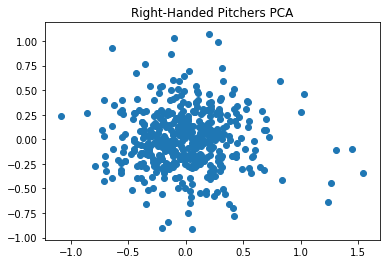

In [17]:
rh_pitcher_data.reset_index(inplace=True, drop=True)

# keep pitcher ID and name
rh_pitcher_data_ID_name = rh_pitcher_data[['pitcher', 'player_name']]

# data for clustering
rh_pitcher_data_clustering = rh_pitcher_data.drop(['pitcher', 'player_name', 'p_throws'], axis=1)
print(f"Number of original dimensions: {rh_pitcher_data_clustering.shape[1]}")

# rescale 
rh_scaler = MinMaxScaler()
rh_pitcher_data_clustering_scaled = pd.DataFrame(rh_scaler.fit_transform(rh_pitcher_data_clustering))

# perform PCA
rh_pca = PCA(n_components=2)

rh_pitcher_data_clustering_pca = pd.DataFrame(rh_pca.fit_transform(rh_pitcher_data_clustering_scaled))

plt.scatter(rh_pitcher_data_clustering_pca[[0]], rh_pitcher_data_clustering_pca[[1]])
plt.title("Right-Handed Pitchers PCA")
plt.show()

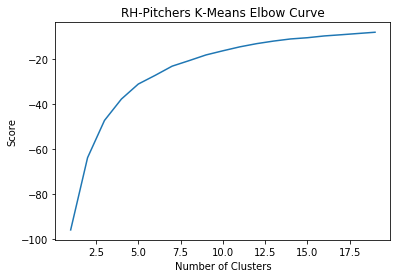

In [18]:
Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]

score = [kmeans[i].fit(rh_pitcher_data_clustering_pca).score(rh_pitcher_data_clustering_pca) for i in range(len(kmeans))]

plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('RH-Pitchers K-Means Elbow Curve')
plt.show()

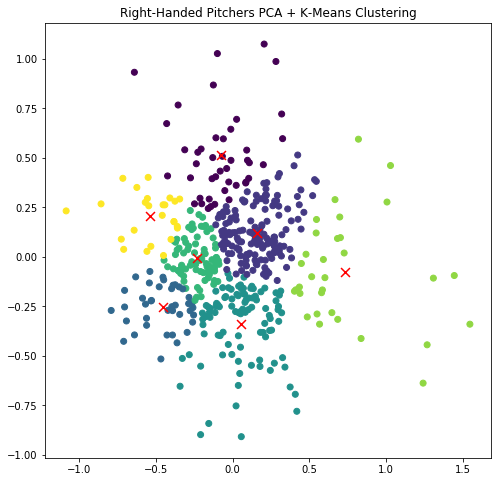

In [36]:
rh_kmeans = KMeans(n_clusters=7).fit(rh_pitcher_data_clustering_pca)

rh_pitcher_data_clustering_pca['cluster_number'] = rh_kmeans.predict(rh_pitcher_data_clustering_pca)

plt.figure(figsize=(8,8))
plt.scatter(rh_pitcher_data_clustering_pca.iloc[:, 0], rh_pitcher_data_clustering_pca.iloc[:, 1], c=rh_kmeans.labels_)
plt.scatter(rh_kmeans.cluster_centers_[:,0], rh_kmeans.cluster_centers_[:,1], marker='x', c='r', s=80)
plt.title("Right-Handed Pitchers PCA + K-Means Clustering")
plt.show()

In [31]:
db = DBSCAN(algorithm='ball_tree').fit(rh_pitcher_data_clustering_pca)
labels = db.labels_
k = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f"Optimal number of clusters: {k}")
print(f"Number of noise points: {n_noise}")

Optimal number of clusters: 7
Number of noise points: 0
